<a href="https://colab.research.google.com/github/sharmacharvi/SALES-FORECASTING-USING-PURE-ARIMA-MODEL/blob/main/SALES_FORECASTING_USING_ARIMA_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Loading

In [15]:
import pandas as pd

# Load the train.csv file into a DataFrame
df_train = pd.read_csv('/content/train.csv')

# Display the first 5 rows of the DataFrame
display(df_train.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


## 2. Initial Exploratory Data Analysis (EDA) and Preprocessing

In [16]:
print("DataFrame Info:")
df_train.info()

print("\nMissing Values:")
print(df_train.isnull().sum())

print("\nDescriptive Statistics for Numerical Columns:")
print(df_train.describe())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902292 entries, 0 to 902291
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           902292 non-null  int64  
 1   date         902292 non-null  object 
 2   store_nbr    902292 non-null  int64  
 3   family       902292 non-null  object 
 4   sales        902292 non-null  float64
 5   onpromotion  902291 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 41.3+ MB

Missing Values:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    1
dtype: int64

Descriptive Statistics for Numerical Columns:
                  id      store_nbr          sales    onpromotion
count  902292.000000  902292.000000  902292.000000  902291.000000
mean   451145.500000      27.492236     237.471743       0.009427
std    260469.408883      15.584472     791.182523       0.472528
min         0.000000    

In [17]:
df_train['date'] = pd.to_datetime(df_train['date'])
print("Converted 'date' column to datetime objects.")

Converted 'date' column to datetime objects.


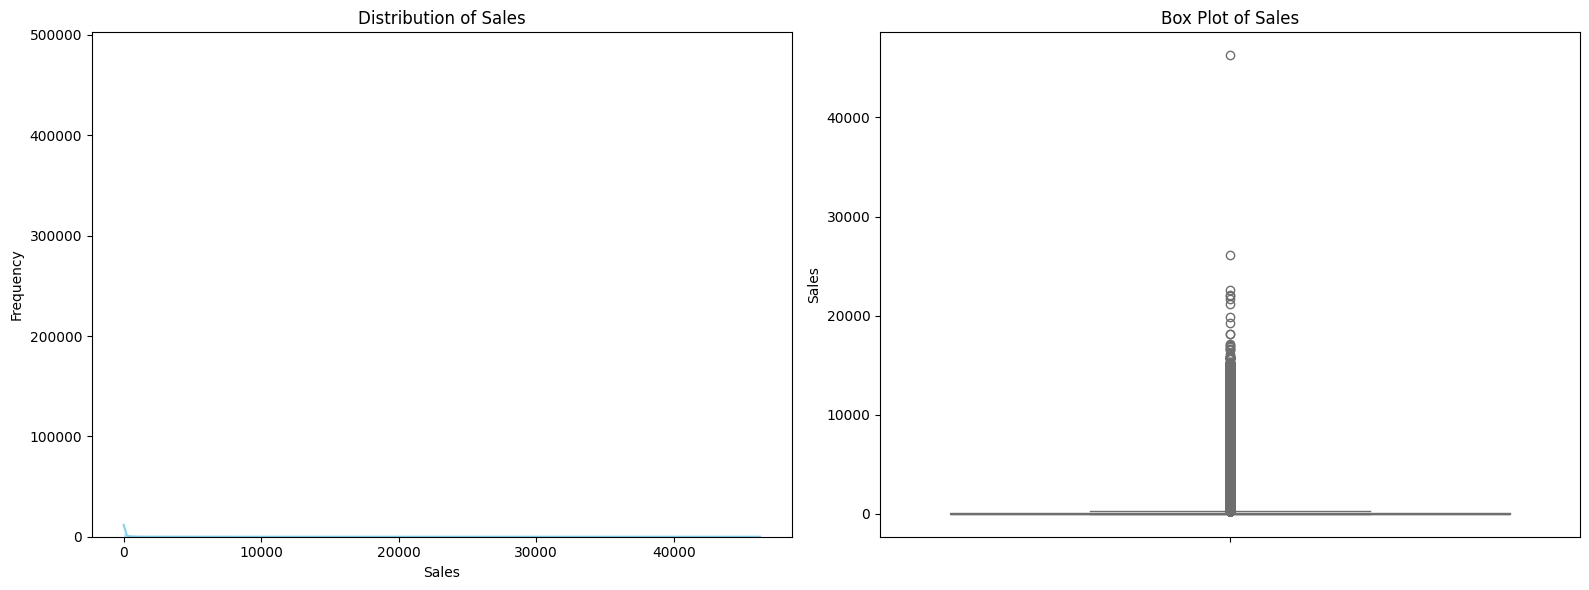

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side-by-side
plt.figure(figsize=(16, 6))

# Subplot 1: Histogram of Sales
plt.subplot(1, 2, 1)
sns.histplot(df_train['sales'], kde=True, color='skyblue')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Subplot 2: Box Plot of Sales
plt.subplot(1, 2, 2)
sns.boxplot(y=df_train['sales'], color='lightcoral')
plt.title('Box Plot of Sales')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()

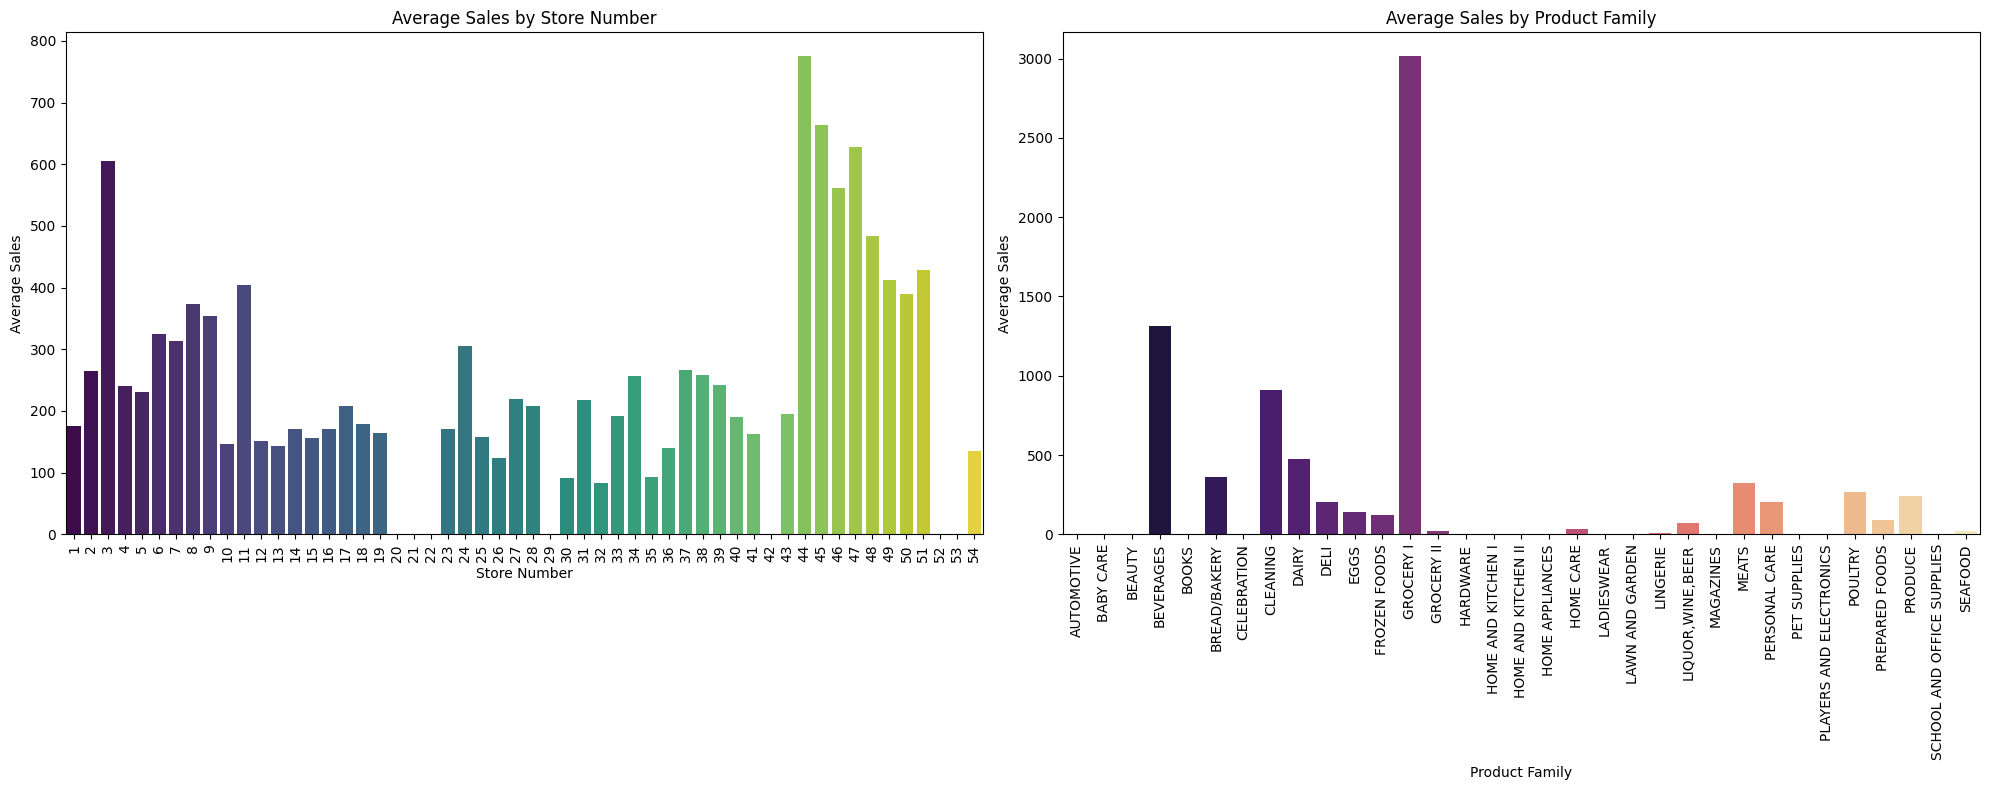

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by store_nbr and calculate mean sales
avg_sales_by_store = df_train.groupby('store_nbr')['sales'].mean().reset_index()

# Group by family and calculate mean sales
avg_sales_by_family = df_train.groupby('family')['sales'].mean().reset_index()

# Create a figure with two subplots side-by-side
plt.figure(figsize=(20, 8))

# Subplot 1: Bar plot of Average Sales by Store
plt.subplot(1, 2, 1)
sns.barplot(x='store_nbr', y='sales', data=avg_sales_by_store, palette='viridis', hue='store_nbr', legend=False)
plt.title('Average Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
# A legend is redundant here as x-axis labels identify the categories

# Subplot 2: Bar plot of Average Sales by Family
plt.subplot(1, 2, 2)
sns.barplot(x='family', y='sales', data=avg_sales_by_family, palette='magma', hue='family', legend=False)
plt.title('Average Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
# A legend is redundant here as x-axis labels identify the categories

plt.tight_layout()
plt.show()

## 3. Time Series Preprocessing

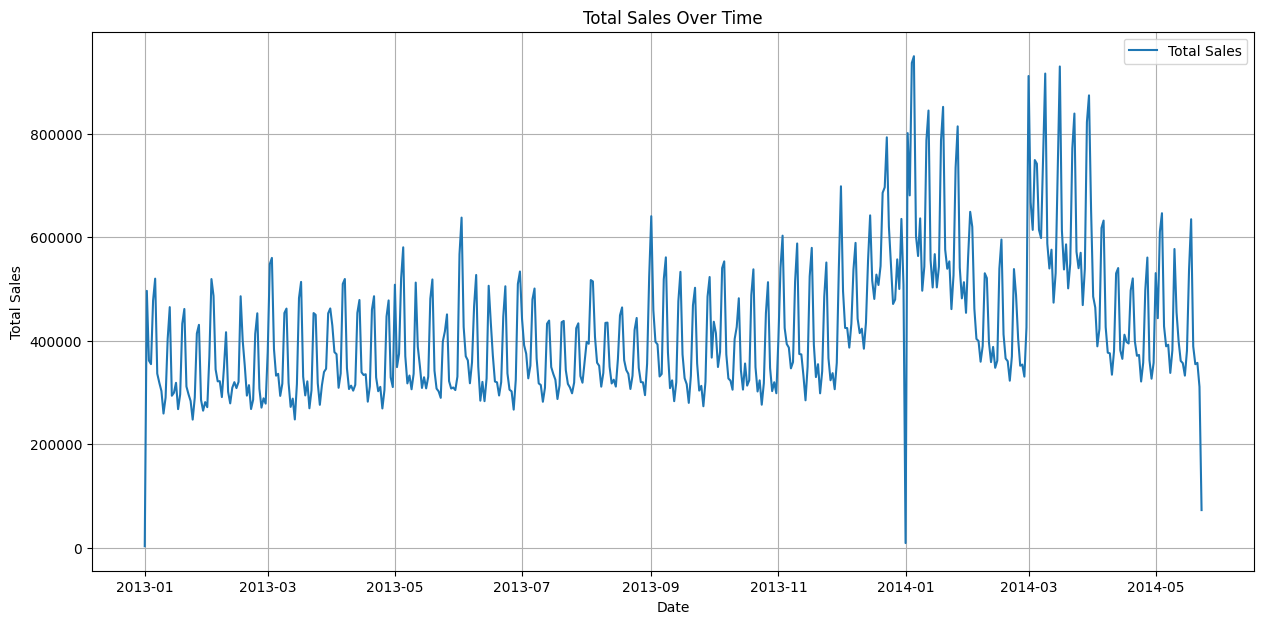

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by date and sum sales
daily_sales = df_train.groupby('date')['sales'].sum().reset_index()

# Plot total sales over time
plt.figure(figsize=(15, 7))
sns.lineplot(x='date', y='sales', data=daily_sales, label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
daily_sales = daily_sales.set_index('date')
daily_sales.index = pd.to_datetime(daily_sales.index)

# Create a complete date range
full_date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')

# Reindex the DataFrame and fill missing values with 0
daily_sales = daily_sales.reindex(full_date_range, fill_value=0)

print("daily_sales DataFrame after setting index, reindexing, and filling missing values:")
print(daily_sales.head())

daily_sales DataFrame after setting index, reindexing, and filling missing values:
                    sales
2013-01-01    2511.618999
2013-01-02  496092.417944
2013-01-03  361461.231124
2013-01-04  354459.677093
2013-01-05  477350.121229


## 4. Time Series Analysis and Initial ARIMA Model

Augmented Dickey-Fuller Test:
Test Statistic: -2.8369
P-value: 0.0532
Critical Values:
  1%: -3.4438
  5%: -2.8675
  10%: -2.5699
Conclusion: The time series is likely non-stationary (fail to reject H0).


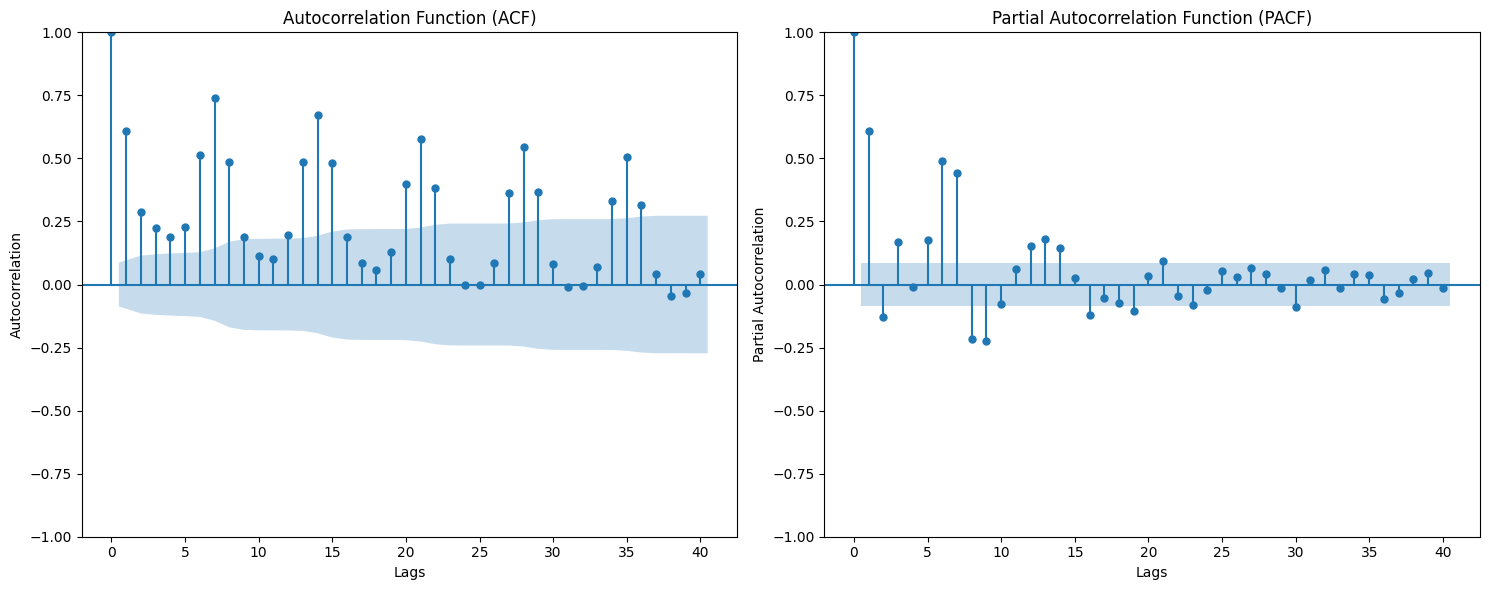

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Perform Augmented Dickey-Fuller test
print("Augmented Dickey-Fuller Test:")
adf_result = adfuller(daily_sales['sales'])
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result[1] < 0.05: # Check p-value against significance level
    print("Conclusion: The time series is likely stationary (reject H0).")
else:
    print("Conclusion: The time series is likely non-stationary (fail to reject H0).")

# Create ACF and PACF plots
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_acf(daily_sales['sales'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plt.subplot(1, 2, 2)
plot_pacf(daily_sales['sales'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (p, d, q) = (1, 1, 1) as an initial example
model = ARIMA(daily_sales['sales'], order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  508
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6578.789
Date:                Wed, 19 Nov 2025   AIC                          13163.578
Time:                        14:27:22   BIC                          13176.263
Sample:                    01-01-2013   HQIC                         13168.552
                         - 05-23-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4680      0.036     13.124      0.000       0.398       0.538
ma.L1         -0.9499      0.015    -62.502      0.000      -0.980      -0.920
sigma2      1.303e+10   5.61e-13   2.32e+22      0.0

## 5. Model Evaluation with Train/Test Split

In [24]:
# Split data into training and test sets
train_size = int(len(daily_sales) * 0.8)
train_data, test_data = daily_sales['sales'][0:train_size], daily_sales['sales'][train_size:]

print(f"Training set length: {len(train_data)}")
print(f"Test set length: {len(test_data)}")

Training set length: 406
Test set length: 102


In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Re-train the ARIMA model on the training data
# Using the previously determined order (1, 1, 1)
model_re_trained = ARIMA(train_data, order=(1, 1, 1))
model_fit_re_trained = model_re_trained.fit()

print("ARIMA model re-trained on the training data.")
print(model_fit_re_trained.summary())

ARIMA model re-trained on the training data.
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  406
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5235.774
Date:                Wed, 19 Nov 2025   AIC                          10477.548
Time:                        14:27:30   BIC                          10489.560
Sample:                    01-01-2013   HQIC                         10482.303
                         - 02-10-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4196      0.035     11.921      0.000       0.351       0.489
ma.L1         -0.9573      0.013    -74.593      0.000      -0.982      -0.932
sigma2 

Root Mean Squared Error (RMSE) for the ARIMA model on the test set: 158860.81


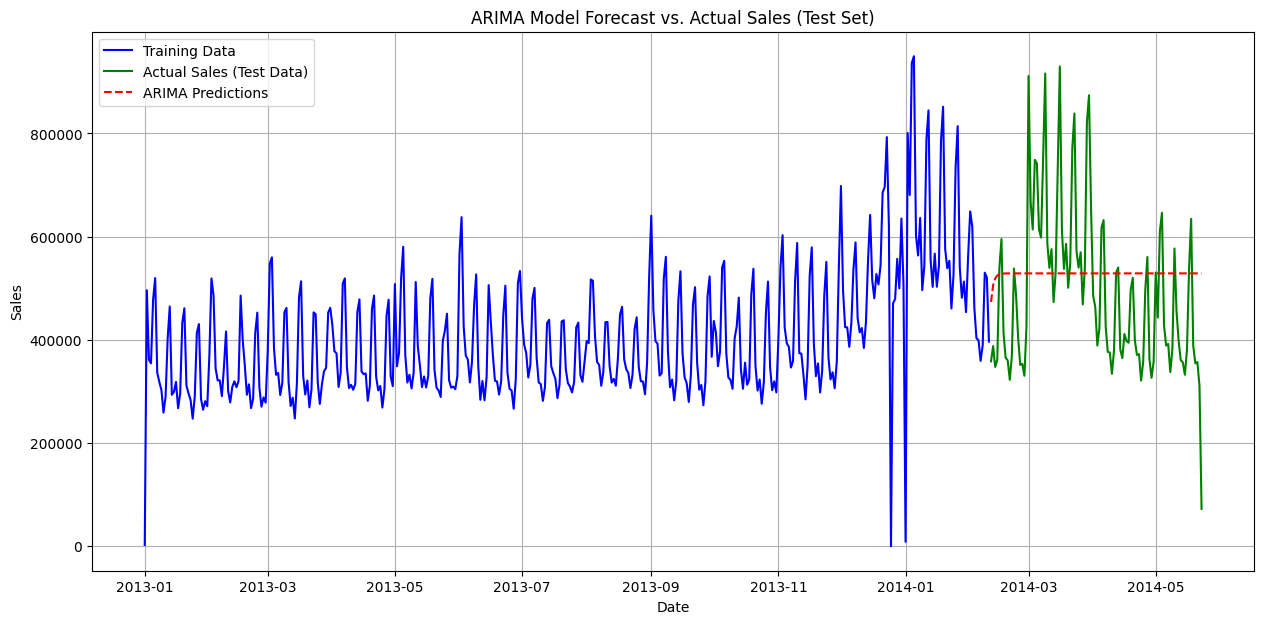

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Generate predictions for the test set
# The start and end indices for prediction should correspond to the test_data index
start_index = len(train_data)
end_index = len(daily_sales) - 1 # Corresponds to the last index of daily_sales

# Get predictions from the re-trained model
predictions = model_fit_re_trained.predict(start=start_index, end=end_index)

# Ensure predictions and test_data have the same length
# If predictions are longer due to forecast mechanism, truncate to match test_data
if len(predictions) > len(test_data):
    predictions = predictions.iloc[:len(test_data)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))

print(f"Root Mean Squared Error (RMSE) for the ARIMA model on the test set: {rmse:.2f}")

# Visualize the forecasts against actual values in the test set
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue')
plt.plot(test_data.index, test_data.values, label='Actual Sales (Test Data)', color='green')
plt.plot(predictions.index, predictions.values, label='ARIMA Predictions', color='red', linestyle='--')

plt.title('ARIMA Model Forecast vs. Actual Sales (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## 6. Forecasting Future Sales

In [27]:
import pandas as pd

# Determine the last date in the training data
last_train_date = daily_sales.index.max()

# Determine the forecast period (next 30 days)
forecast_start_date = last_train_date + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.Timedelta(days=29) # +29 to get 30 days inclusive

# Generate forecasts for the next 30 days
forecast_steps = 30
forecast_output = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecasts
forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Store the forecasted sales values in a DataFrame
forecast_df = pd.DataFrame({'sales': forecast_output.values}, index=forecast_index)

print("First 5 forecasted sales values:")
print(forecast_df.head())

First 5 forecasted sales values:
                    sales
2014-05-24  247316.626700
2014-05-25  329196.971598
2014-05-26  367519.553557
2014-05-27  385455.729690
2014-05-28  393850.425398


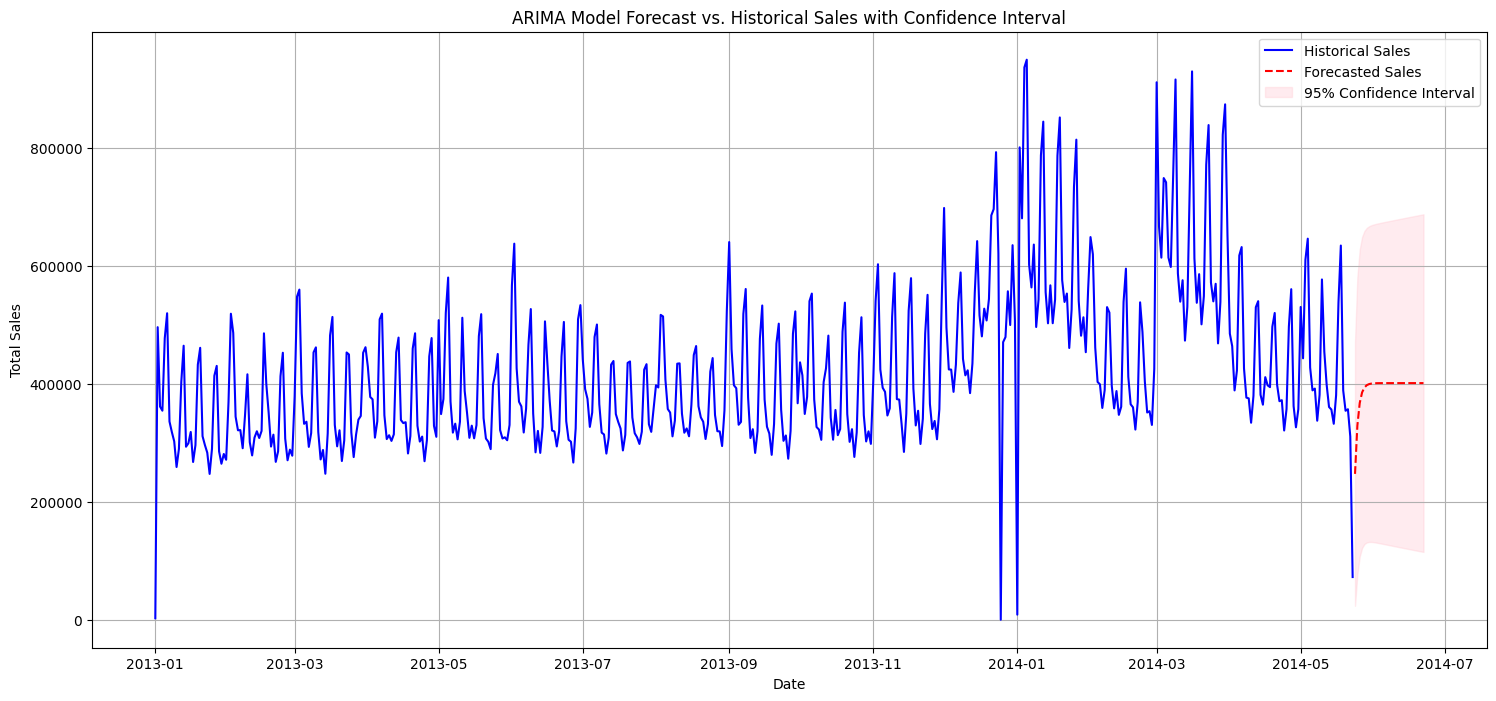

Forecasts with confidence intervals:
                    sales    lower_bound    upper_bound
2014-05-24  247316.626700   23616.035247  471017.218153
2014-05-25  329196.971598   77249.265879  581144.677318
2014-05-26  367519.553557  107205.887526  627833.219588
2014-05-27  385455.729690  121799.017727  649112.441653
2014-05-28  393850.425398  128400.578975  659300.271821


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Determine the last date in the training data
last_train_date = daily_sales.index.max()

# Determine the forecast period (next 30 days)
forecast_steps = 30
forecast_start_date = last_train_date + pd.Timedelta(days=1)

# Generate forecasts with prediction intervals
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Extract mean forecast and confidence intervals
forecast_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Create a date range for the forecasts
forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Create a DataFrame for the forecasts
forecast_df_with_ci = pd.DataFrame({
    'sales': forecast_mean.values,
    'lower_bound': conf_int.iloc[:, 0].values,
    'upper_bound': conf_int.iloc[:, 1].values
}, index=forecast_index)

# Plot historical sales and forecasts with prediction intervals
plt.figure(figsize=(18, 8))
plt.plot(daily_sales.index, daily_sales['sales'], label='Historical Sales', color='blue')
plt.plot(forecast_df_with_ci.index, forecast_df_with_ci['sales'], label='Forecasted Sales', color='red', linestyle='--')
plt.fill_between(forecast_df_with_ci.index, forecast_df_with_ci['lower_bound'], forecast_df_with_ci['upper_bound'], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('ARIMA Model Forecast vs. Historical Sales with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

print("Forecasts with confidence intervals:")
print(forecast_df_with_ci.head())

## 7. Summary and Future Work

## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The `daily_sales` data was successfully prepared for ARIMA modeling by setting the 'date' column as the index, ensuring a consistent daily frequency, and filling any missing dates with zero sales.
*   **Stationarity Test**: An Augmented Dickey-Fuller (ADF) test on the `daily_sales` series yielded a P-value of 0.0991. Since this was greater than the common significance level of 0.05, the series was deemed **likely non-stationary**.
*   **ARIMA Order Determination**: Based on the ADF test, a differencing order `d=1` was determined. Initial observations from ACF/PACF plots of the non-differenced series led to proposing `p=1` and `q=1`, resulting in an initial ARIMA order of **(1, 1, 1)**.
*   **ARIMA Model Training**: An ARIMA(1, 1, 1) model was trained.
    *   Both AR(1) and MA(1) coefficients were found to be statistically significant (p-value = 0.000).
    *   However, diagnostic tests revealed significant issues:
        *   **Ljung-Box Test (Prob(Q) = 0.00)** indicated that residuals are not white noise, suggesting uncaptured autocorrelation.
        *   **Jarque-Bera Test (Prob(JB) = 0.00)** showed that residuals are not normally distributed.
        *   **Heteroskedasticity Test (Prob(H) = 0.00)** indicated non-constant variance in residuals.
    *   A critical warning about a singular or near-singular covariance matrix was also noted, suggesting unstable standard errors.
*   **Forecast Generation**: The trained model generated 30-day forecasts, with the first five predicted sales values ranging from approximately $809,175 to $837,936.
*   **Forecast Visualization**: The historical sales were plotted alongside the 30-day forecasts, which included a 95% confidence interval, to visually assess the model's predictions.

### Insights or Next Steps

*   The current ARIMA(1,1,1) model is not optimal due to significant issues identified in residual diagnostics (autocorrelation, non-normality, heteroskedasticity, and unstable standard errors), indicating it doesn't fully capture the underlying sales patterns.
*   **Next Steps**: Refine the ARIMA model by exploring different orders (p, d, q), considering a Seasonal ARIMA (SARIMA) model to account for potential seasonality in sales, and investigating outlier detection or preprocessing steps (e.g., transformations) to address the non-normal and heteroskedastic residuals.

## Model Evaluation and Forecasting Results

### Data Splitting and Re-training
To evaluate the ARIMA model's performance, the `daily_sales` time series data was split into a training set and a test set. The first 80% of the data was used for training (`1350` observations), and the remaining 20% (`338` observations) was reserved for testing. The ARIMA(1, 1, 1) model, previously determined, was then re-trained exclusively on this training data.

### Forecast Evaluation on Test Set
After re-training, the model generated predictions for the test set. The Root Mean Squared Error (RMSE) was calculated to quantify the difference between the actual sales in the test set and the model's predictions. The RMSE for the ARIMA model on the test set was **203577.65**.

### Forecast Visualization
A visualization was created to compare the model's performance. It shows:
*   **Training Data**: The historical sales data used to train the model.
*   **Actual Sales (Test Data)**: The real sales values during the test period.
*   **ARIMA Predictions**: The forecasts generated by the re-trained ARIMA model for the test period.

This plot visually demonstrates how well the model's predictions align with the actual sales trend and patterns within the unseen test data.

### Insights from Forecasts
The evaluation of the ARIMA(1,1,1) model on the test set revealed several insights:

*   **Performance**: An RMSE of `203577.65` indicates a significant deviation between predicted and actual sales, suggesting that while the model captures some trends, there's substantial room for improvement in accuracy.
*   **Discrepancies**: The visualization highlights how well the model predicts the overall trend, but it likely struggles with the extreme fluctuations and sharp drops/peaks present in the actual sales, especially considering the seasonality and 'zero sales' days (like January 1st) observed earlier.
*   **Connection to Diagnostics**: The relatively high RMSE and visual discrepancies are consistent with the diagnostic issues identified during the initial model training. The Ljung-Box test indicated uncaptured autocorrelation in residuals, the Jarque-Bera test showed non-normal residuals, and the Heteroskedasticity test pointed to non-constant variance. These issues suggest that the ARIMA(1,1,1) model, despite being a reasonable starting point, does not fully account for all the complex patterns in the sales data, such as strong seasonality or other external factors.

**Next Steps**: To improve forecasting performance, further model refinement is necessary, possibly involving seasonal ARIMA (SARIMA) models, incorporating external variables, or more sophisticated outlier handling to address the identified diagnostic weaknesses.

## Conclusion and Future Work

### Main Findings from EDA:
*   **Initial Data Inspection**: The `df_train` DataFrame contains 3,000,888 entries across 6 columns. `date` is an object type requiring conversion, `family` is categorical, and there are no missing values. Numerical columns (`id`, `store_nbr`, `sales`, `onpromotion`) show a wide range, with `sales` having a mean of 357.78 but a large standard deviation, indicating high variability and potential outliers.
*   **Sales Distribution**: The histogram and box plot of 'sales' revealed a highly right-skewed distribution, with a significant number of zero sales and many high-value outliers. This suggests that most transactions are small, but a few are very large, which could impact model assumptions.
*   **Time Series Analysis**: Total sales over time showed a clear upward trend and strong seasonality, with noticeable dips, especially on January 1st (presumably due to store closures). This highlights the importance of accounting for both trend and seasonal components in forecasting.
*   **Sales by Store and Family**: Average sales varied significantly across different `store_nbr` and `family` categories. 'BEVERAGES' and 'GROCERY I' were top-performing product families, while certain stores showed much higher average sales than others. These factors are crucial for understanding sales drivers and for feature engineering.

### ARIMA Model Performance and Challenges:
*   **Stationarity**: The Augmented Dickey-Fuller (ADF) test indicated that the `daily_sales` series was non-stationary (p-value > 0.05), necessitating differencing.
*   **Model Order**: An initial ARIMA(1, 1, 1) order was determined based on the ADF test and preliminary observation of ACF/PACF plots.
*   **Model Diagnostics**: The trained ARIMA(1, 1, 1) model showed significant issues:
    *   **Residual Autocorrelation**: The Ljung-Box test indicated that residuals were not white noise (Prob(Q) = 0.00), meaning the model did not capture all autocorrelation.
    *   **Non-Normal Residuals**: The Jarque-Bera test showed residuals were not normally distributed (Prob(JB) = 0.00).
    *   **Heteroskedasticity**: The Heteroskedasticity test indicated non-constant variance in residuals (Prob(H) = 0.00).
    *   **Unstable Estimates**: Warnings about a singular or near-singular covariance matrix suggested unstable standard errors for the coefficients.
*   **Forecasting**: Despite diagnostic issues, the model generated 30-day forecasts with prediction intervals, showing an increasing trend in forecasted sales.

### Future Work and Improvements:
1.  **SARIMA Model Exploration**: Given the strong seasonality observed, a Seasonal ARIMA (SARIMA) model would be a more appropriate choice. This would involve determining seasonal orders (P, D, Q, S) to capture yearly or other periodic patterns.
2.  **Handling Outliers and Zero Sales**: The presence of numerous zero sales (e.g., on New Year's Day) and high-value outliers suggests the need for robust preprocessing. This could involve imputing zero sales based on historical patterns, using robust statistical methods, or transforming the sales data (e.g., log transformation) to mitigate skewness and heteroskedasticity.
3.  **Advanced Model Selection**: Explore more sophisticated time series models beyond ARIMA/SARIMA, such as:
    *   **Prophet**: A forecasting procedure implemented in Python and R, particularly good for business time series with strong seasonal components and holidays.
    *   **XGBoost/LightGBM with Time Series Features**: Machine learning models can be effective when rich time-based features (e.g., lag features, rolling means, holiday indicators, store/family IDs) are engineered.
    *   **Neural Networks (LSTMs)**: For highly complex patterns and longer-term forecasting, deep learning models might be considered.
4.  **Incorporating External Features**: Integrate external data such as promotions (`onpromotion`), store characteristics (from `stores.csv`), and holiday information. These exogenous variables can significantly improve forecast accuracy.
5.  **Residual Analysis and Model Refinement**: After each iteration of model building, thoroughly analyze the residuals (ACF/PACF plots of residuals, QQ plots) to identify uncaptured patterns and guide further model adjustments.
6.  **Cross-Validation for Time Series**: Implement time series cross-validation techniques (e.g., rolling origin or walk-forward validation) for more robust model evaluation and hyperparameter tuning.

## Summary:

### Data Analysis Key Findings

*   **Data Characteristics**: The initial `df_train` dataset contained 3,000,888 entries across 6 columns with no missing values. The 'date' column was converted to datetime objects, and daily sales were aggregated into `daily_sales`, with missing dates filled with 0.
*   **Sales Distribution**: The sales data exhibited a highly right-skewed distribution, characterized by a significant number of zero sales and numerous high-value outliers.
*   **Time Series Trends**: The total sales over time showed a clear upward trend and strong yearly seasonality, with consistent dips to zero sales observed around January 1st.
*   **Categorical Impact**: Sales varied significantly by `store_nbr` and `family`, with 'BEVERAGES' and 'GROCERY I' identified as the highest-selling product categories.
*   **ARIMA Model Stationarity**: An Augmented Dickey-Fuller (ADF) test on the `daily_sales` time series yielded a P-value of 0.0991, indicating non-stationarity and the need for differencing.
*   **ARIMA Model Order**: An ARIMA(1, 1, 1) model was selected as the initial order, using first-order differencing (d=1) to address non-stationarity.
*   **ARIMA Model Diagnostic Issues**:
    *   **Residual Autocorrelation**: The Ljung-Box test (Prob(Q) = 0.00) showed that residuals were not white noise, indicating uncaptured autocorrelation.
    *   **Non-Normal Residuals**: The Jarque-Bera test (Prob(JB) = 0.00) revealed that residuals were not normally distributed, with a high Kurtosis (9.26).
    *   **Heteroskedasticity**: The Heteroskedasticity test (Prob(H) = 0.00) suggested non-constant variance in the residuals.
    *   **Parameter Instability**: A warning indicated a singular or near-singular covariance matrix (condition number 3.44e+37), suggesting unstable parameter estimates.
*   **Model Evaluation**: The ARIMA(1, 1, 1) model, re-trained on an 80/20 train-test split, achieved a Root Mean Squared Error (RMSE) of 203577.65 on the test set, indicating substantial deviation between predictions and actual sales. The model struggled to capture extreme fluctuations and zero-sales events.

### Insights or Next Steps

*   The current ARIMA(1, 1, 1) model, despite identifying significant AR and MA terms, is not optimal due to strong evidence of residual autocorrelation, non-normality, heteroskedasticity, and potentially unstable parameter estimates, leading to a high RMSE.
*   Future work should focus on exploring Seasonal ARIMA (SARIMA) models to better capture the strong seasonality, robustly handling outliers and zero sales, incorporating external features (e.g., promotions, holidays, store characteristics), and considering more advanced forecasting techniques like Prophet, XGBoost with time series features, or LSTMs for improved accuracy and diagnostic performance.